# Vítejte ve světě RDKitu
Podívat se můžete na http://www.rdkit.org/docs/GettingStartedInPython.html

In [1]:
# nepostradatelné importy
# Chem je základní balík, který umožňuje základní operace se strukturami
from rdkit import Chem

# nadstavba nad ním je rdkit.Chem.AllChem, který ho nahrazuje a rozšiřuje, ale déle se nahrává
# from rdkit.Chem import AllChem as Chem

# balík Draw slouží pro vykreslení struktury
from rdkit.Chem import Draw

## Práce s jednou molekulou

In [2]:
# struktura zapsaná ve SMILES
m = Chem.MolFromSmiles("c1c(C(C)C)c(O)ccc1CCNC")

In [3]:
# jak taková struktura vypadá v SDF souboru (spojení několika molfilů dohromady)
print(Chem.MolToMolBlock(m))


     RDKit          

 14 14  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0

## Kreslící cvičení
Atomy v kruhu obarvíme (přiřadíme 1) zelenou a heteroatomy mimo kruh obarvíme (-1) červeně.
K tomu využijeme knihovnu Draw

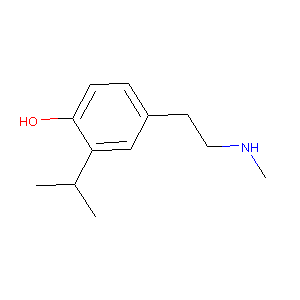

In [4]:
Draw.MolToImage(m)

In [5]:
# na kreslení podobnosti struktur, popř. by tím šly kreslit velikosti nábojů aj.
from rdkit.Chem.Draw import SimilarityMaps

# nakreslí strukturu a dovolí její část zvýraznit
from rdkit.Chem.Draw import rdMolDraw2D

# aby jupyter uměl vykreslit svg
from IPython.display import SVG

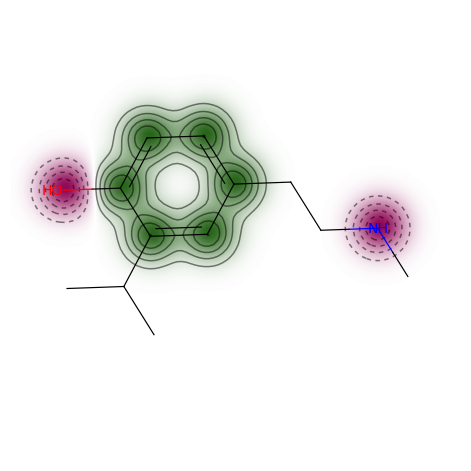

In [6]:
atom_ring_info = m.GetRingInfo().AtomRings()
contribs = [1.0 if atom.GetIdx() in atom_ring_info[0] else 0.0 if atom.GetAtomicNum() == 6 else -1 for atom in m.GetAtoms()]
SimilarityMaps.GetSimilarityMapFromWeights(m, contribs)

In [7]:
atom = m.GetAtoms()[0]
atom.GetIdx()

0

In [8]:
def molToSVG(mol, atoms=[]):
    # needs 2D coordinates
    copy = Chem.Mol(mol)
    copy.Compute2DCoords()
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(copy, highlightAtoms=atoms)
    drawer.FinishDrawing()
    return drawer.GetDrawingText().replace('svg:','')

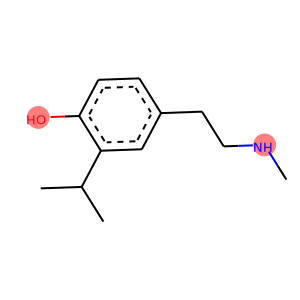

In [9]:
# zvýrazní heteroatomy
SVG(molToSVG(m,atoms=[x for x,y in enumerate(m.GetAtoms()) if y.GetAtomicNum() != 6]))

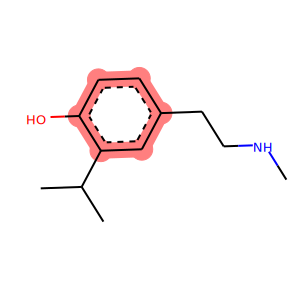

In [10]:
# zvýrazní aromatické atomy
SVG(molToSVG(m,atoms=[x for x,y in enumerate(m.GetAtoms()) if y.GetIsAromatic()]))

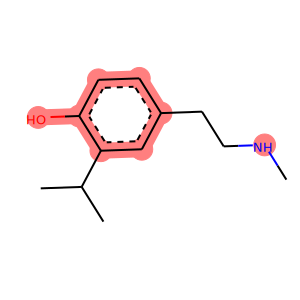

In [11]:
# sjednocení obou zvýraznění
aroms = [x for x,y in enumerate(m.GetAtoms()) if y.GetIsAromatic()]
hetes = [x for x,y in enumerate(m.GetAtoms()) if y.GetAtomicNum() != 6]
atoms = []
atoms.extend(aroms)
atoms.extend(hetes)
SVG(molToSVG(m,atoms))

## Práce s chemickou knihovnou (SDF souborem)

In [12]:
# knihovna Lipinského deskriptorů
from rdkit.Chem import Lipinski

In [13]:
# SDF reader (supplier) je iterovatelný, jen je potřeba si zkontrolovat, zda náhodou nevrátil None
drugbank_input = Chem.SDMolSupplier('../data/drugbank.sdf')

In [14]:
drugbank = [m for m in drugbank_input if m]
aromatic_drugs = [m for m in drugbank if Lipinski.NumAromaticRings(m) > 0]

In [15]:
print(len(drugbank))
print(len(aromatic_drugs))

7110
5166


In [16]:
# vybereme léčiva, která neobsahují benzen
# SMARTS patern pro benzen
pattern = Chem.MolFromSmarts('c1ccccc1')
non_matching_drugs = [m for m in aromatic_drugs if not m.HasSubstructMatch(pattern)]
len(non_matching_drugs)

880

In [17]:
# vybereme léčiva, která obsahují podstrukturu kyseliny benzoové
benzoovka = Chem.MolFromSmarts('c1ccccc1C(=O)O')
obsahuje_benzoovku = [m for m in aromatic_drugs if m.HasSubstructMatch(benzoovka)]
len(obsahuje_benzoovku)

267

In [18]:
# můžeme hledat i se dvěma
obsahuje_vice_benzoovek = [m for m in obsahuje_benzoovku if len(m.GetSubstructMatches(benzoovka)) > 1]
len(obsahuje_vice_benzoovek)

22

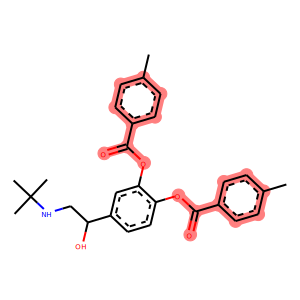

In [19]:
# zvýrazníme si, kde podstrukture je
m = obsahuje_vice_benzoovek[0]
atoms = set()
# sjednocení všech atomů, které se účastní námi vybrané podstruktury, použil jsem set, ale určitě se dají použít i jiné metody
for subst in m.GetSubstructMatches(benzoovka):
    atoms = atoms.union(subst)
SVG(molToSVG(m, atoms))

In [20]:
# průměrný počet kruhů v lčivech
rings = sum(Chem.GetSSSR(d) for d in drugbank) 
avg_rings = rings/len(drugbank)
print(avg_rings)

2.466807313642757


## Převedení SDF do CSV souboru
Z drugbanku uděláme csv soubor a ke každému léčivu vypočítáme deskriptory

In [21]:
# knihova, která obstarává práci s csv soubory, jak jejich zapisování, tak i čtení
import csv

# knihovna, která obstarává práci s inchi
from rdkit.Chem import rdinchi

# knihovny pro výpočet deskriptorů, je potřeba se podívat, jaký deskriptor je kde
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors

In [22]:
# drugbank máme stále v paměti ve stejnojmenné proměnné

# blok s ošetřeným zavíráním zdrojů
with open('drugbank.csv', 'w') as csvfile:
    # vytvoření instance writeru
    error_counter = 0
    drugbank_writer = csv.writer(csvfile, delimiter=',',
                                 quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # hlavička souboru
    drugbank_writer.writerow(['inchikey', 'smiles', 'molwt', 'logP', 'HBA', 'HBD'])
    for drug in drugbank:
        try:
            inchi = rdinchi.MolToInchi(drug)[0]
            inchikey = rdinchi.InchiToInchiKey(inchi)
        # u některých struktur se nedaří vytvořit inchi a vyhodí výjimku, kterou je potřeba ošetřit
        except ValueError:
            error_counter += 1
            inchi = None
            # zkusíme jestli nějaké inchi není načteno už z sdf
            if "INCHI_KEY" in drug.GetPropNames():
                inchikey = drug.GetProp("INCHI_KEY")
            else:
                inchikey = "Chyba_" + error_counter
        drugbank_writer.writerow([inchikey,
                                  Chem.MolToSmiles(drug),
                                  Descriptors.MolWt(drug),
                                  Descriptors.MolLogP(drug),
                                  rdescriptors.CalcNumLipinskiHBA(drug),
                                  rdescriptors.CalcNumLipinskiHBD(drug)])


Získání léčiv, která nejsou druglike podle Lipinského, tj. nesmí porušit víc než jedno pravidlo (hmotnost do 500Da, logP<5, počet akceptorů vodíku menší než 10 a donorů menší než 5)

In [23]:
def lipinski_wt_limit(m):
    return Descriptors.MolWt(m) <= 500

def lipinski_logp_limit(m):
    return Descriptors.MolLogP(m) <= 5

def lipinski_hba_limit(m):
    return rdescriptors.CalcNumLipinskiHBA(m) <= 10

def lipinski_hbd_limit(m):
    return rdescriptors.CalcNumLipinskiHBD(m) <= 5

def lipinski_violations(m):
    return 4 - sum((lipinski_wt_limit(m),
                    lipinski_logp_limit(m),
                    lipinski_hba_limit(m),
                    lipinski_hbd_limit(m)))

In [24]:
non_druglike = [(m, lipinski_violations(m)) for m in drugbank if lipinski_violations(m) > 1]
len(non_druglike)

919

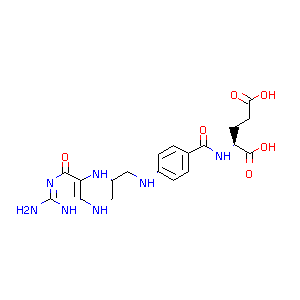

In [25]:
m = non_druglike[8][0]
Draw.MolToImage(m)

In [26]:
# co naše léčivo nesplňuje?
print(lipinski_wt_limit(m), lipinski_logp_limit(m), lipinski_hba_limit(m), lipinski_hbd_limit(m))

True True False False
